In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [31]:
import pandas as pd
import numpy as np

In [32]:
data1=pd.read_csv('../input/clusters-aptos-dataset/cluster_three.csv')

In [4]:
data1.drop(['Cluster'],inplace=True,axis=1)

In [5]:
data1.Actual.value_counts()

0    877
2     37
1     19
4      9
3      1
Name: Actual, dtype: int64

In [6]:
from numpy.random import RandomState
import pandas as pd

rng = RandomState()

train_df = data1.sample(frac=0.7, random_state=rng)
test_df = data1.loc[~data1.index.isin(train_df.index)]

In [7]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,Actual
492,0,1,0,0,1,1,1,1,2,3,...,0,0,0,0,0,0,0,0,0,0
289,1,0,1,1,1,1,1,1,1,3,...,1,1,0,0,0,0,0,0,0,0
864,0,0,1,0,0,1,1,0,3,3,...,1,1,1,1,0,1,0,0,0,4
383,0,1,0,1,1,1,2,2,3,3,...,0,1,0,0,0,0,0,0,0,0
934,1,1,1,1,1,0,1,2,3,3,...,0,1,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,0,1,0,0,1,1,0,2,2,3,...,0,0,0,0,0,0,0,0,0,0
373,0,0,2,1,2,0,1,1,3,2,...,0,0,0,0,0,0,0,0,0,0
375,2,0,1,0,2,1,2,2,5,4,...,1,0,1,1,1,1,0,0,1,0
543,1,1,0,1,1,3,2,3,2,4,...,1,1,0,1,1,1,1,1,0,0


In [ ]:
train_df.iloc[0, 784]

In [8]:
import torch
import cv2
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from PIL import ImageFile
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch.nn as nn
import torch.nn.functional as f
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(0)
import sys
from sklearn.model_selection import train_test_split

In [9]:
IMAGE_SIZE = 28 
transform = transforms.Compose([
                                transforms.ToPILImage(),

                                transforms.Grayscale(), 
                                transforms.RandomRotation(20,expand=True), 
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                               ])

In [10]:
class Dataset_Create(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = file_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, we use ToTensor(), so we define the numpy array like (H, W, C)
        image = self.data.iloc[index, :784].values.astype(np.uint8).reshape((28, 28, 1))
        label = self.data.iloc[index, 784]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [11]:
train_dataset = Dataset_Create(train_df, transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

In [12]:
len(train_loader)

33

In [13]:
test_dataset = Dataset_Create(test_df, transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['Actual'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
 
print(class_weights) #Prints the calculated weights for the classes.

tensor([  0.2150,  13.2000,   4.7143, 132.0000,  18.8571], device='cuda:0')


In [16]:
class Net1(nn.Module): # Module is library package
    
    def __init__(self):
        super().__init__()
        
        self.fc1=nn.Linear(784, 200)  #flatten the image 
        self.fc2=nn.Linear(200,200)
        self.fc3=nn.Linear(200,200)
        self.fc4=nn.Linear(200,200)  
        self.fc5=nn.Linear(200,200)
        self.fc6=nn.Linear(200,5)
        
    def forward(self,x): # pass the data
        
        x = x.view(-1, 28 * 28)         
        x=f.relu(self.fc1(x))
        x=f.relu(self.fc2(x))
        x=f.relu(self.fc3(x))
        x=f.relu(self.fc4(x))
        x=f.relu(self.fc5(x))
        
        x=self.fc6(x)
        
        return x
               

net1=Net1()
print(net1)
net1.cuda()

Net1(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=5, bias=True)
)


Net1(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=5, bias=True)
)

In [17]:
dataiter = iter(train_loader)
images, labels = dataiter.next() 
images.shape

torch.Size([20, 1, 28, 28])

In [18]:
optimizer =  optim.Adam(net1.parameters(), lr=0.001)
 
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [19]:
Path='./three.pth'
all_tranning_loss=[]
all_validation_loss=[]
all_tranning_accuracy=[]
all_validation_accuracy=[]

steps = 0
num_epochs=20

for epoch in range(0,num_epochs):
    net1.train()
    phase = 'tranning'
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    running_loss = 0.0
    running_corrects = 0
    for i,(inputs, labels) in enumerate(train_loader):
                
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net1(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # running_loss += loss.item() * inputs.size(0)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        steps += 1
        
    
    steps = 0
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects.double().item() /len(train_loader.dataset)
    all_tranning_loss.append(loss.item())
    all_tranning_accuracy.append(epoch_acc)


    print("\n")
    print("----------------------------Tranning Summary----------------------")
    print('{} Tranning Avg. Loss: {:.4f} Tranning Avg. Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
    print("-"*70)
    print("\n")
 
    net1.eval()
    
    with torch.no_grad():
        phase = "validation"
        running_loss = 0.0
        running_corrects = 0
        for i,(inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net1(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)  
            
        epoch_val_loss = running_loss / len(test_loader)
        epoch_val_acc = running_corrects.double().item() /len(test_loader.dataset)
        all_validation_loss.append(epoch_val_loss)
        all_validation_accuracy.append(epoch_val_acc)

        print()
        print("----------------------------Validation Summary-----------------")
        print('{} Validation Avg. Loss: {:.4f} Validation Avg. Acc: {:.4f}'.format(
                    phase, epoch_val_loss, epoch_val_acc))
        print("------------------------------------------------------------")
        
    net1.train()

torch.save(net1.state_dict(), Path)

Epoch 0/19
----------


----------------------------Tranning Summary----------------------
tranning Tranning Avg. Loss: 1.5288 Tranning Avg. Acc: 0.8136
----------------------------------------------------------------------



----------------------------Validation Summary-----------------
validation Validation Avg. Loss: 1.3294 Validation Avg. Acc: 0.9293
------------------------------------------------------------
Epoch 1/19
----------


----------------------------Tranning Summary----------------------
tranning Tranning Avg. Loss: 1.4464 Tranning Avg. Acc: 0.7970
----------------------------------------------------------------------



----------------------------Validation Summary-----------------
validation Validation Avg. Loss: 1.3096 Validation Avg. Acc: 0.9293
------------------------------------------------------------
Epoch 2/19
----------


----------------------------Tranning Summary----------------------
tranning Tranning Avg. Loss: 1.4184 Tranning Avg. Acc: 0.9303
-------

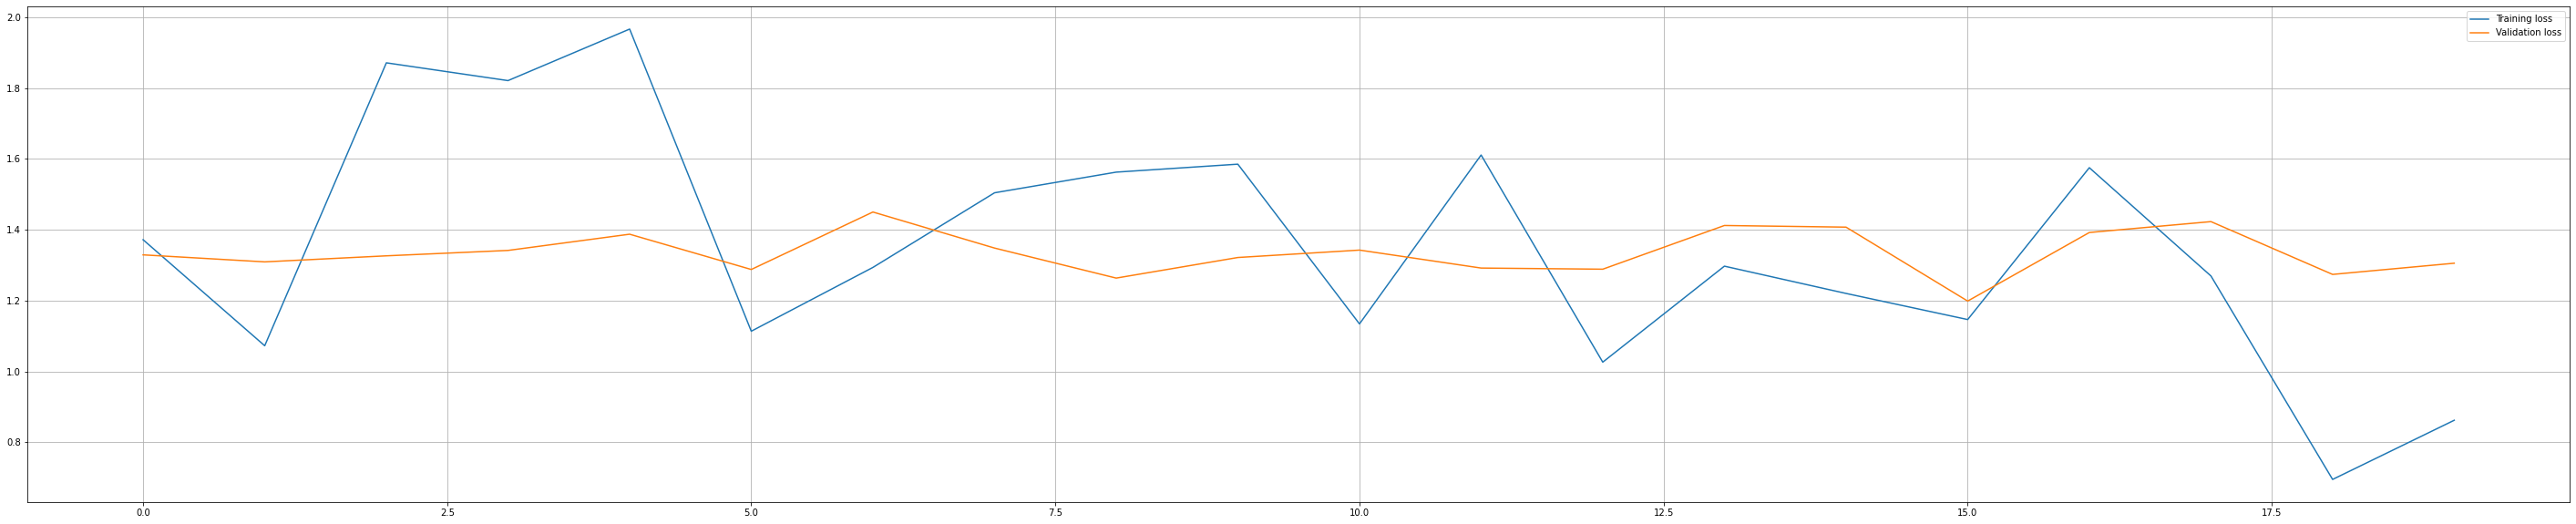

In [20]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(all_tranning_loss, label='Training loss')
plt.plot(all_validation_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.show()

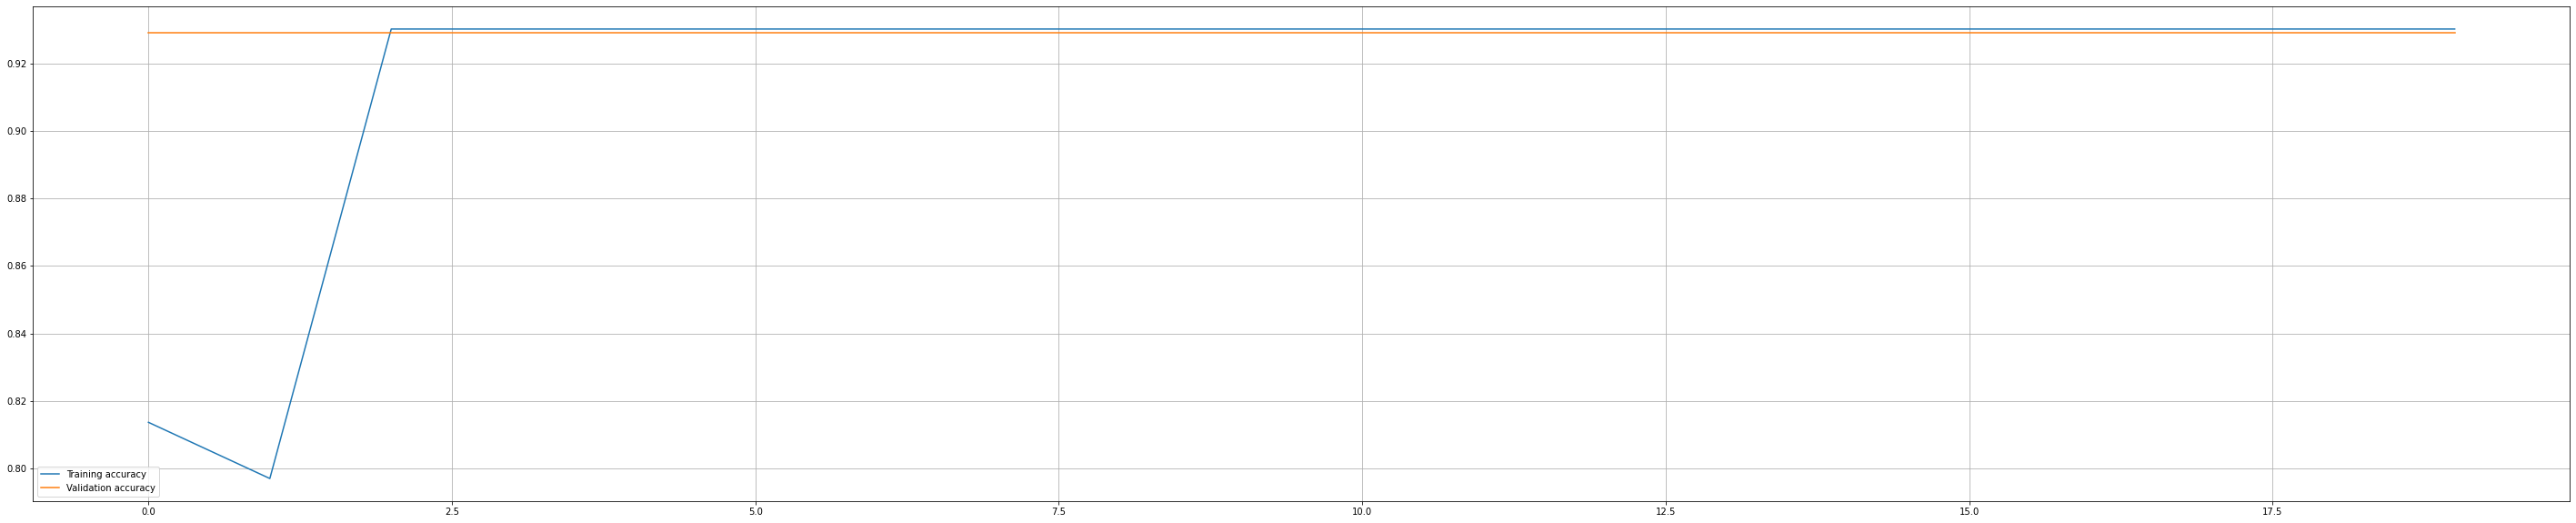

In [21]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(all_tranning_accuracy, label='Training accuracy')
plt.plot(all_validation_accuracy, label='Validation accuracy')
plt.legend()
plt.grid()
plt.show()

In [22]:
correct=0
total=0
with torch.no_grad():
    for data in test_loader:
        X,y=data
        X, y = X.to(device), y.to(device)
        
        output=net1(X)
        for idx, i in enumerate(output):
            if torch.argmax(i)==y[idx]:
                correct+=1
            total+=1
            
print(round(correct/total,3))

0.929


In [23]:
y_true_tensor = torch.tensor([]).cuda()
y_pred_tensor = torch.tensor([]).cuda()
net1.eval()
for i,(inputs, labels) in enumerate(test_loader):

  inputs, labels = inputs.to(device), labels.to(device)
  outputs = net1(inputs)
  _, preds = torch.max(outputs, 1)
  y_true_tensor = torch.cat((y_true_tensor,labels))
  y_pred_tensor = torch.cat((y_pred_tensor,preds))

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [25]:
y_true = y_true_tensor.tolist()
y_pred = y_pred_tensor.tolist()
matrice = confusion_matrix(y_true,y_pred)
matrice


array([[263,   0,   0,   0],
       [  9,   0,   0,   0],
       [  9,   0,   0,   0],
       [  2,   0,   0,   0]])

In [30]:
classify_report = classification_report(y_true, y_pred, target_names=['0', '1', '2', '4'])
print(classify_report)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       263
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         2

    accuracy                           0.93       283
   macro avg       0.23      0.25      0.24       283
weighted avg       0.86      0.93      0.90       283



In [29]:
test_df['Actual'].value_counts()

0    263
2      9
1      9
4      2
Name: Actual, dtype: int64